# Статистические и вероятностные методы обнаружения аномалий

In [1]:
# Импортируем необходимые библиотеки
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

import scipy

from sklearn.covariance import EllipticEnvelope


In [2]:
data = pd.read_csv("./data/boston_house_prices.csv",header=1)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Потренируемся на бостонском датасете. Данные о ценах на дома в Бостоне, сам датасет включает в себя следующие колонки:

- CRIM: Per capita crime rate by town
- ZN: Proportion of residential land zoned for lots over 25,000 sq. ft
- INDUS: Proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: Nitric oxide concentration (parts per 10 million)
- RM: Average number of rooms per dwelling
- AGE: Proportion of owner-occupied units built prior to 1940
- DIS: Weighted distances to five Boston employment centers
- RAD: Index of accessibility to radial highways
- TAX: Full-value property tax rate per \$10,000
- PTRATIO: Pupil-teacher ratio by town
- B: 1000(Bk — 0.63)², where Bk is the proportion of people by town
- LSTAT: Percentage of lower status of the population
- MEDV: Median value of owner-occupied homes in \$1000s

In [10]:
# Загрузим данные, возьмем 2 группы признаков: RAD и PTRATION
X1 = data[['RAD','PTRATIO']]

# RM и LSTAT
X2 = data[['RM', 'LSTAT']]

display(X1.head(), X2.head())

,RAD,PTRATIO
0,1,15.3
1,2,17.8
2,2,17.8
3,3,18.7
4,3,18.7


,RM,LSTAT
0,6.575,4.98
1,6.421,9.14
2,7.185,4.03
3,6.998,2.94
4,7.147,5.33


## Поиск аномалий с помощью BoxPlot и IQR

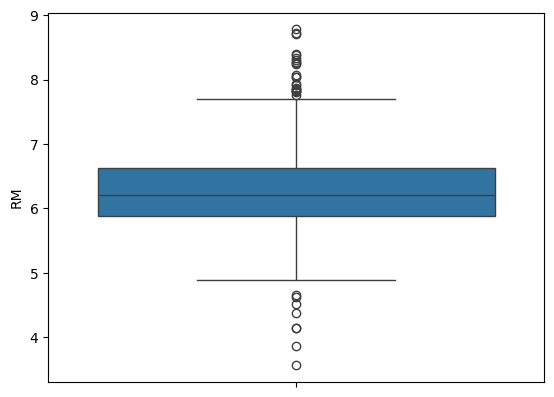

In [4]:
# Построим BoxPlot по признакам из X2 и посмотрим, есть ли выбросы
sns.boxplot(X2.iloc[:, 0]);

Мы видим, что дома с >8 квартирами могут быть восприняты как выбросы

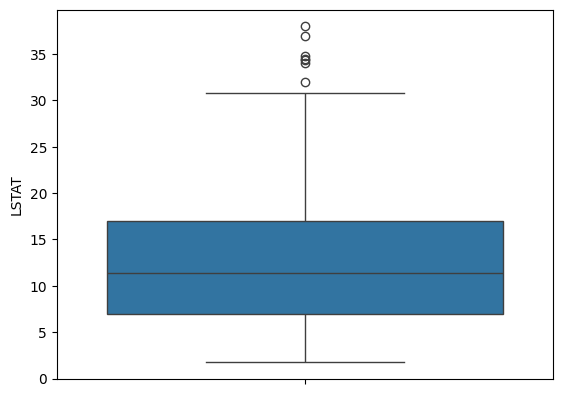

In [5]:
sns.boxplot(X2.iloc[:, 1]);

Видим, что районы, в которых бедного населения > 30% тоже можно рассматривать как выбросы

In [6]:
# Чтобы посчитать IQR отдельно от графика можно воспользоваться либо numpy, либо scipy
iqr = np.percentile(X2.iloc[:, 1], 75) - np.percentile(X2.iloc[:, 1], 25)
print(iqr)


iqr = scipy.stats.iqr(X2.iloc[:, 1])
print(iqr)

10.005000000000003
10.005000000000003


---

### Задание модуля:
Сколько точек предполагаются аномальными при оценке accessibility to radial highways статистическим способом?

$Q1-1.5IQR, Q3+1.5IQR$

In [7]:
data_array = X1["RAD"]

iqr = scipy.stats.iqr(data_array)
lower_bound = data_array.quantile(0.25) - iqr * 1.5
upper_bound = data_array.quantile(0.75) + iqr * 1.5

answer = len(data_array[(data_array < lower_bound) | (data_array > upper_bound)])

print(answer)

0


Сколько точек предполагаются аномальными при оценке pupil-teacher ratio by town статистическим способом?

$Q1-1.5IQR,Q3+1.5IQR$

In [14]:
data_array = X1["PTRATIO"]

iqr = scipy.stats.iqr(data_array)
lower_bound = round(data_array.quantile(0.25) - iqr * 1.5)
upper_bound = round(data_array.quantile(0.75) + iqr * 1.5)

answer = len(data_array[(data_array < lower_bound) | (data_array > upper_bound)])

print(answer)

3


---

# Оценка распределения и дисперсии распределения для поиска аномалий

Давайте оценим дисперсии выборок в предположении о нормальном распределении

Text(0.5, 0, 'pupil-teatcher ratio by town')

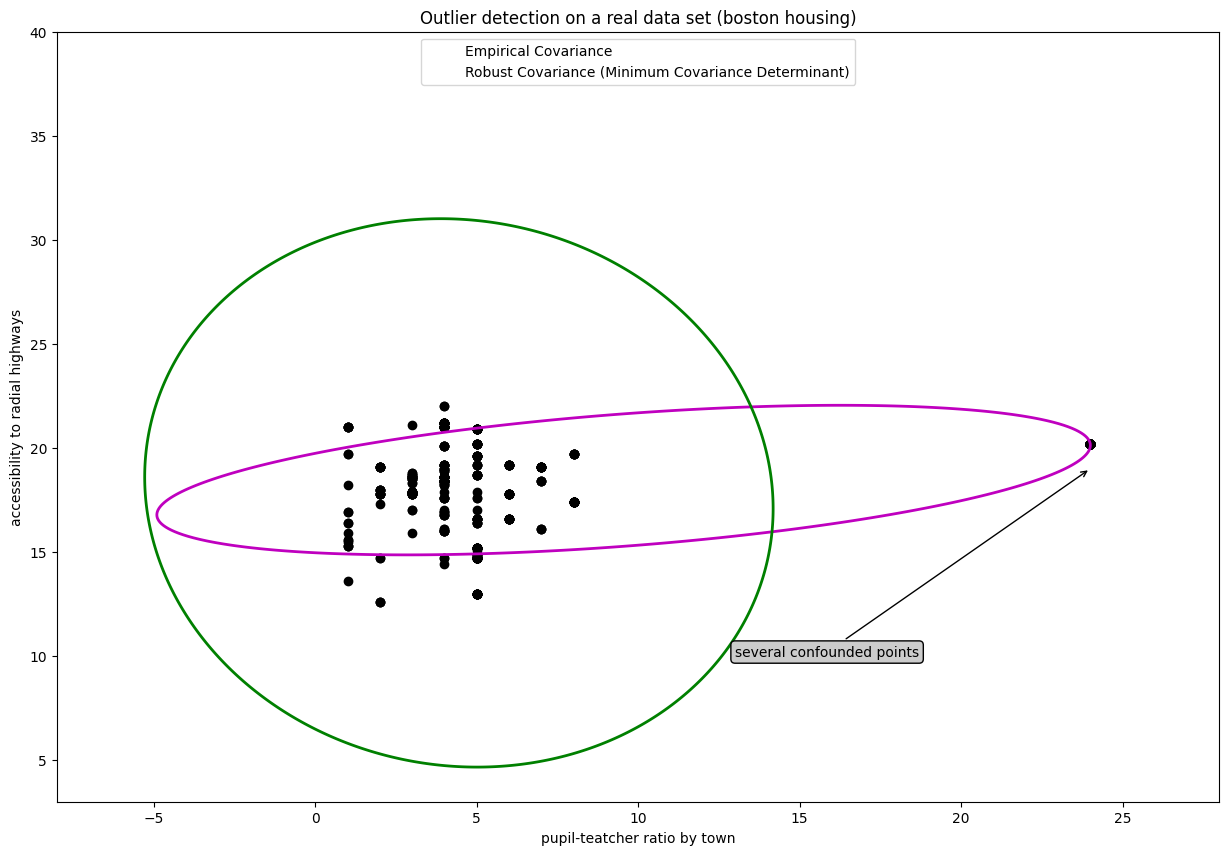

In [9]:
# Алгоритмы оценки ковариационной матрицы
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(
        contamination=0.261
    ),
}

colors = ["m", "g", "b"]

figure(figsize=(15, 10))
legend1 = {}
legend2 = {}

# Код для визуализации
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X1.iloc[:, 0], X1.iloc[:, 1], color="black")

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

plt.annotate(
    "several confounded points",
    xy=(24, 19),
    xycoords="data",
    textcoords="data",
    xytext=(13, 10),
    bbox=bbox_args,
    arrowprops=arrow_args,
)

plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend(
    (legend1_values_list[0].collections[0], legend1_values_list[1].collections[0]),
    (legend1_keys_list[0], legend1_keys_list[1]),
    loc="upper center",
)

plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teatcher ratio by town")